# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using JLD;
using BSON: @save, @load # save mode

In [2]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


In [3]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

# Create Reinforcement Learning Environment

In [4]:
# TODO: set as desired
R_TOL = 1.0;
N_WAYPOINTS = 4; # including startpoint, >= 2
SLOW_MODE = true;
TRAINING = false;
EVALUATION = false;

In [5]:
# Parametric Constructor for a subtype of AbstractEnv
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv 
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environoments
    visualization::Bool # visualization
    realtime::Bool # realtime
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # Δ time
    
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    norm_way::T
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T # tolerance within drones has to reach waypoint
    projected_position::Vector{T} # projected position of drone along trajectory

    slow_mode::Bool # slow flight learning mode
end

In [6]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along z
            
            typemin(T)..typemax(T), # orientation along x
            typemin(T)..typemax(T), # orientation along z
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x (next gate - current position)
            typemin(T)..typemax(T), # position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # way to next next gate z (next next gate - next gate)
            ], 
    )
    
    num_waypoints = N_WAYPOINTS # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints + 1) # trajectory with num_waypoints waypoints (+ start point), (with dummy points) 
    reached_goal = falses(num_waypoints)
    
    norm_way = 0.0 
    for i in 1:(num_waypoints - 1)
        norm_way += norm(waypoints[i] - waypoints[i + 1])
    end
    
    if visualization #visualizes VTOL and waypoints
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
        visualize_waypoints(waypoints[1:num_waypoints], 0.15)
    end

    environment = VtolEnv(
        action_space,
        state_space, 
        zeros(T, length(state_space)), # current state, needs to be extended
        rand(action_space), #initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        
        num_waypoints, # includig start point
        waypoints, 
        reached_goal,
        
        norm_way, # norm_way
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3), # projected_position

        SLOW_MODE # slow_mode
    )
    
    
    reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [7]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[6]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, norm_way::T, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T, projected_position::Vector{T}, slow_mode::Bool) where {A, T, ACT, R<:AbstractRNG} in Main at In[5]:3

# Define the RL interface

In [8]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [9]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_position::Vector{T}, v_B::Vector{T}) where T
    
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_position) > d_max
            s_gd = exp(-norm(x_W - projected_position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end;

In [10]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    
    if env.slow_mode
        v_min = 1.0 # min velocity
        v_max = 3.0 # max velocity
        d_max = 0.5 
    else
        v_min = 4.0 # min velocity
        v_max = 50.0 # max velocity
        d_max = 1.0 
    end


    s = scale_for_slowmode(true, v_min, v_max, d_max, env.x_W, env.projected_position, env.v_B)
    
    k_p = 5.0 * s #/ env.norm_way # factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt) / env.norm_way # factor for reached distance (overall) reward
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 50.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    # factor for too high body rate penalty
    if env.slow_mode
        k_ω = 0.01
    else
        k_ω = 0.001
    end
    norm_ω = norm(env.ω_B[3]) # penalty for body rate

    if env.x_W[3] < -2
        fall = 1
    else
        fall = 0
    end
    
    if !env.slow_mode
        k_s /= env.norm_way
        k_p /= env.norm_way
    end

    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω - fall 
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [11]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];
    
    
    env.waypoints = generate_trajectory(env.num_waypoints + 1); # Dummy points
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    
    if env.visualization
        visualize_waypoints(env.waypoints[1:env.num_waypoints], 0.15); 
    end
    
    norm_way = 0.0 
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    env.norm_way = norm_way
    env.progress = 0.0;
    env.progress_prev = 0.0;
    
    
    env.state = [env.x_W[1]; # position along x
                 env.x_W[3]; # position along z
        
                 env.R_W[1,1]; # orientation along x
                 env.R_W[3,1]; # orientation along z
        
                 env.v_B[1]; # velocity along x BODY coordinates
                 env.v_B[2]; # velocity along y BODY coordinates  
        
                 env.ω_B[3]; # rotational velocity along z BODY coordinates
        
                 env.waypoints[2][1] - env.x_W[1]; # position error to next gate along x
                 env.waypoints[2][3] - env.x_W[3]; # position error to next gate along z
                 
                 env.waypoints[3][1] - env.waypoints[2][1]; # way to next next gate x 
                 env.waypoints[3][3] - env.waypoints[2][3]] # way to next next gate z 
        
    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    env.projected_position = [0; 0; 0]
    
    nothing

end;

In [12]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [13]:
env = VtolEnv();

In [14]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[12]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [15]:
function _step!(env::VtolEnv, next_action)
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    
    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_position = calculate_progress(env.waypoints, env.x_W)

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
        
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.2, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end
    end
 

    env.t += env.Δt
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[3]; # position along z
    
    env.state[3] = env.R_W[1,1]; # orientation along x
    env.state[4] = env.R_W[3,1]; # orientation along z
    
    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates
    
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
      
    env.state[8] = env.waypoints[env.current_point][1] - env.x_W[1]; # position error along x, dummy integriert
    env.state[9] = env.waypoints[env.current_point][3] - env.x_W[3]; # position error along z, dummy integriert
    
    if env.current_point <= env.num_waypoints
        env.state[10] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1] ; # way to next next gate x (next next gate - next gate), dummy integriert
        env.state[11] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # way to next next gate z (next next gate - next gate), dummy integriert
    end
        
    
    # Termination criteria
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast_point 
        env.x_W[3] < -5.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 3.0 ||# stop after 3s per point
        norm(env.x_W - env.projected_position) > 5.0 || # too far off the path 
        env.reached_goal == trues(env.num_waypoints)

    nothing
end;

In [16]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.7s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.674594454441571e9, 1.674594457167686e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [17]:
seed = 123    
rng = StableRNG(seed)
N_ENV = 8
UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ])

MultiThreadEnv(8 x VtolEnv)

In [18]:
# Define the function approximator
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),#
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [19]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


In [20]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)
    if SLOW_MODE
        f = joinpath("./RL_models_slow/", "vtol_2D_ppo_$t.bson")
    else
        f = joinpath("./RL_models_fast/", "vtol_2D_ppo_$t.bson") 
    end
    @save f model
    println("parameters at step $t saved to $f")
end;

In [21]:
function loadModel()
    f = joinpath("./RL_models_slow/", "vtol_2D_ppo_$(load_from_slow_step).bson") 
    @load f model
    return model
end;

In [22]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

visualize_validation = true; # TODO: set as desired
episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = visualize_validation, realtime = visualize_validation);

In [23]:
# TODO: set as desired
# number of steps
steps_slow = 1_500_000 
steps_fast = 1_500_000
load_from_slow_step = 500_000 

save_freq = 10_000
validate_freq = 10_000



steps = 0
if SLOW_MODE
    steps = steps_slow
else
    steps = steps_fast
end

1500000

In [24]:
if !SLOW_MODE
    agent.policy.approximator = loadModel(); 
end;

In [25]:
if TRAINING
    ReinforcementLearning.run(
        agent,
        env,
        StopAfterStep(steps),
        ComposedHook(
            DoEveryNStep(saveModel, n=save_freq), 
            DoEveryNStep(validate_policy, n=validate_freq)),
    )
end

In [26]:
if TRAINING
    plot(episode_test_reward_hook.rewards)
end

In [27]:
close_visualization(); # closes the MeshCat visualization

# Evaluation

In [28]:
test_env = VtolEnv(;name = "testVTOL");

In [29]:
function loadModel(path, num)
    f = joinpath(path, "vtol_2D_ppo_$num.bson") 
    @load f model
    return model
end;

In [30]:
function validate(num_models, num_test)
    episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
    # create a env only for reward test
    for i in 1:num_models
          
        sum_rewards_model = 0;
        sum_successes_model = 0;
        sum_avg_vel_model = 0;
        sum_compl_time = 0;
        n_success = 0;
        
        for exp in 1:num_test
            if SLOW_MODE
                path = "./RL_models_slow/"
            else
                path = "./RL_models_fast/"
            end
            agent.policy.approximator = loadModel(path, i * save_freq); 
            RLBase.reset!(test_env)
            run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
            # the result of the hook
            sum_rewards_model += episode_test_reward_hook.rewards[end];
            
            if test_env.reached_goal == trues(test_env.num_waypoints)
                n_success += 1
                sum_avg_vel_model += test_env.norm_way / test_env.t
                sum_compl_time += test_env.t
            end
        end
        
        rewards[i] = sum_rewards_model / num_test;
        success_rate[i] = n_success / num_test;
        if n_success > 0
            avg_velocity[i] = sum_avg_vel_model / n_success;
            avg_compl_time[i] = sum_compl_time / n_success;
        else
            avg_velocity[i] = NaN
            avg_compl_time[i] = NaN
        end
        percent = percent = round(i * 100 / num_models, digits=2)
        print("progress: $(percent)%   \r")
        flush(stdout)
        
    end
    
    
end;

In [31]:
if EVALUATION
    
    num_model = Int(steps / save_freq);
    num_test = 200; # TODO: change as desired 

    rewards = zeros(num_model, 1);
    success_rate = zeros(num_model, 1);
    avg_velocity = zeros(num_model, 1);
    avg_compl_time = zeros(num_model, 1);

    validate(num_model, num_test);
    
    results_path = pwd() * "/plots/";
    if SLOW_MODE
        results_path = results_path * "slow/"
    else
        results_path = results_path * "fast/"
    end
    
    save(results_path * "iterations.jld", "data", [1:num_model] * save_freq)
    
    save(results_path * "avg_comp_time.jld", "data", avg_compl_time)
    
    save(results_path * "avg_velocity.jld", "data", avg_velocity)
    
    save(results_path * "reward.jld", "data", rewards) 
        
    save(results_path * "success_rate.jld", "data", success_rate)
    
end;

In [32]:
results_path = pwd() * "/plots/";
if SLOW_MODE
    results_path = results_path * "slow/"
else
    results_path = results_path * "fast/"
end

iterations = load(results_path * "iterations.jld")["data"];
avg_compl_time = load(results_path * "avg_comp_time.jld")["data"];
avg_velocity = load(results_path * "avg_velocity.jld")["data"];
rewards = load(results_path * "reward.jld")["data"];
success_rate = load(results_path * "success_rate.jld")["data"];

In [33]:
fig_path = pwd() * "/plots/";
if SLOW_MODE
    fig_path = fig_path * "slow/"
else
    fig_path = fig_path * "fast/"
end

"/home/larissa/Documents/Projects/Advanced Deep Learning for Robotics/ADLR_project/src/2d/plots/slow/"

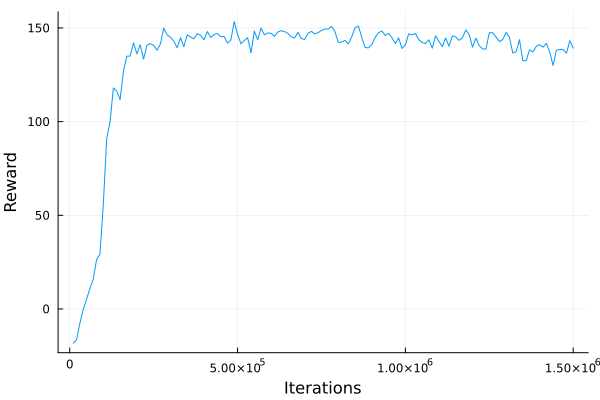

In [34]:
plot(iterations, rewards, xlabel="Iterations", ylabel="Reward", legend = false, xformatter = :scientific)

In [35]:
savefig(fig_path * "reward.svg")

"/home/larissa/Documents/Projects/Advanced Deep Learning for Robotics/ADLR_project/src/2d/plots/slow/reward.svg"

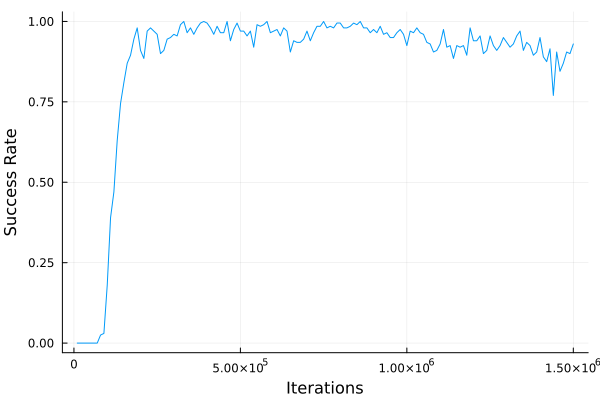

In [36]:
plot(iterations, success_rate, xlabel="Iterations", ylabel="Success Rate", legend = false, xformatter = :scientific)

In [37]:
savefig(fig_path * "success_rate.svg")

"/home/larissa/Documents/Projects/Advanced Deep Learning for Robotics/ADLR_project/src/2d/plots/slow/success_rate.svg"

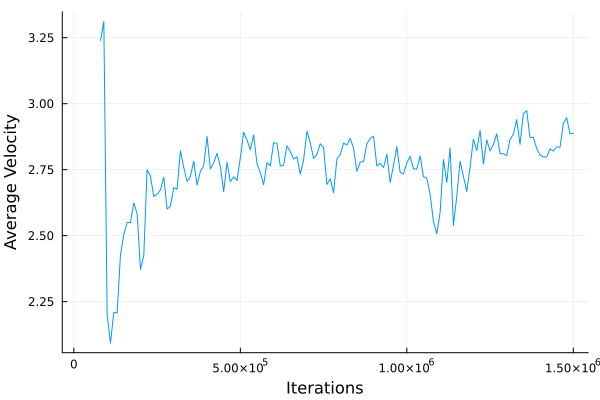

In [38]:
plot(iterations, avg_velocity, xlabel="Iterations", ylabel="Average Velocity", legend = false, xformatter = :scientific)

In [39]:
savefig(fig_path * "avg_velocity.svg")

"/home/larissa/Documents/Projects/Advanced Deep Learning for Robotics/ADLR_project/src/2d/plots/slow/avg_velocity.svg"

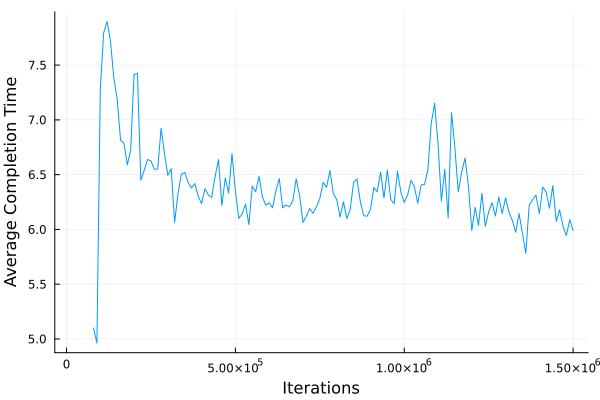

In [40]:
plot(iterations, avg_compl_time, xlabel="Iterations", ylabel="Average Completion Time", legend = false, xformatter = :scientific)

In [41]:
savefig(fig_path * "avg_comp_time.svg")

"/home/larissa/Documents/Projects/Advanced Deep Learning for Robotics/ADLR_project/src/2d/plots/slow/avg_comp_time.svg"

# Create Videos

In [44]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8703


In [46]:
# TODO: load_model as desired
vid_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

if SLOW_MODE
    path = "./RL_models_slow/"
    load_model = 500_000
    println("slow mode")
else
    path = "./RL_models_fast/"
    load_model = 1_250_000
    println("fast mode")
end
agent.policy.approximator = loadModel(path,load_model); 
RLBase.reset!(vid_env)
run(agent.policy, vid_env, StopAfterEpisode(1))

fast mode


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


EmptyHook()

In [43]:
close_visualization();

done